In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [ ]:
class FeatureFilter(BaseEstimator, TransformerMixin):
    """
    Keeps only expected features for the model.
    Adds missing features with NaN and maintains correct order.
    """
    def __init__(self, expected_features):
        self.expected_features = expected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X[[c for c in self.expected_features if c in X.columns]]
        for c in self.expected_features:
            if c not in X.columns:
                X[c] = np.nan
        return X[self.expected_features]

In [ ]:
df = pd.read_csv('/content/Crop_recommendation.csv')

In [ ]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [ ]:
df = df.rename(columns={
    'N': 'nitrogen',
    'P': 'phosphorus',
    'K': 'potassium',
    'temperature': 't2m_c',
    'humidity': 'rh_pct',
    'rainfall': 'tp_m'
})

In [ ]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [ ]:
df2 = pd.read_csv('/content/historical_data_SCIENTIFIC_NPK_FINAL_UNIFIED.csv')

In [ ]:
df2.head()

,id,location_name,latitude,longitude,year,month,sand,silt,clay,soc,...,updated_at,nitrogen,phosphorus,potassium,soil_version_year,soil_data_year,npk_estimation_method,npk_correction_date,soc_unit,cec_unit
0,743,Alexandria,31.2001,29.9187,2017,1,41.9,32.6,25.4,36.4,...,2025-11-21 20:19:35.197,0.317,35.0,142.6,2017,2017,"Scientific (Brady&Weil 2008, Sparks 2003, Havl...",2025-12-25T22:56:39.861521,g/kg,cmol/kg
1,744,Alexandria,31.2001,29.9187,2017,2,41.9,32.6,25.4,36.4,...,2025-11-21 20:19:35.197,0.317,35.0,142.6,2017,2017,"Scientific (Brady&Weil 2008, Sparks 2003, Havl...",2025-12-25T22:56:39.861521,g/kg,cmol/kg
2,745,Alexandria,31.2001,29.9187,2017,3,41.9,32.6,25.4,36.4,...,2025-11-21 20:19:35.197,0.317,35.0,142.6,2017,2017,"Scientific (Brady&Weil 2008, Sparks 2003, Havl...",2025-12-25T22:56:39.861521,g/kg,cmol/kg
3,746,Alexandria,31.2001,29.9187,2017,4,41.9,32.6,25.4,36.4,...,2025-11-21 20:19:35.197,0.317,35.0,142.6,2017,2017,"Scientific (Brady&Weil 2008, Sparks 2003, Havl...",2025-12-25T22:56:39.861521,g/kg,cmol/kg
4,747,Alexandria,31.2001,29.9187,2017,5,41.9,32.6,25.4,36.4,...,2025-11-21 20:19:35.197,0.317,35.0,142.6,2017,2017,"Scientific (Brady&Weil 2008, Sparks 2003, Havl...",2025-12-25T22:56:39.861521,g/kg,cmol/kg


In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3554.0,2.519509e+03,1.026111e+03,7.430000e+02,1.631250e+03,2.519500e+03,3.407750e+03,4.312000e+03
latitude,3554.0,2.933838e+01,2.210556e+00,2.350000e+01,2.810990e+01,3.028000e+01,3.115010e+01,3.150000e+01
longitude,3554.0,3.122417e+01,1.735515e+00,2.551950e+01,3.075030e+01,3.120890e+01,3.226540e+01,3.397530e+01
year,3554.0,2.021006e+03,2.582762e+00,2.017000e+03,2.019000e+03,2.021000e+03,2.023000e+03,2.025000e+03
month,3554.0,6.488745e+00,3.454666e+00,1.000000e+00,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
sand,3554.0,4.445810e+01,7.450606e+00,3.470000e+01,3.910000e+01,4.190000e+01,5.110000e+01,5.980000e+01
silt,3554.0,2.756770e+01,4.589115e+00,1.800000e+01,2.390000e+01,2.810000e+01,3.010000e+01,3.480000e+01
clay,3554.0,2.800101e+01,4.655532e+00,1.790000e+01,2.510000e+01,2.690000e+01,3.070000e+01,3.620000e+01
soc,3338.0,3.312786e+01,2.160409e+01,3.400000e+00,1.920000e+01,2.750000e+01,4.600000e+01,1.108000e+02
ph,3554.0,7.730838e+00,3.154079e-01,7.100000e+00,7.500000e+00,7.900000e+00,8.000000e+00,8.200000e+00


In [ ]:
df2.columns

Index(['id', 'location_name', 'latitude', 'longitude', 'year', 'month', 'sand',
       'silt', 'clay', 'soc', 'ph', 'bdod', 'cec', 'ndvi', 't2m_c', 'td2m_c',
       'rh_pct', 'tp_m', 'ssrd_jm2', 'lc_type1', 'ndvi_source',
       'climate_source', 'lc_source', 'data_quality_score', 'created_at',
       'updated_at', 'nitrogen', 'phosphorus', 'potassium',
       'soil_version_year', 'soil_data_year', 'npk_estimation_method',
       'npk_correction_date', 'soc_unit', 'cec_unit'],
      dtype='object')

In [ ]:
''' drop 'id', 'location_name', 'latitude', 'longitude', 'ndvi_source',
       'climate_source', 'lc_source', 'data_quality_score', 'created_at',
       'updated_at', 'soil_version_year', 'soil_data_year',
       'npk_estimation_method', 'npk_correction_date', 'soc_unit', 'cec_unit' '''
df2.drop(columns=['id', 'location_name', 'latitude', 'longitude', 'ndvi_source',
       'climate_source', 'lc_source', 'data_quality_score', 'created_at',
       'updated_at', 'soil_version_year', 'soil_data_year',
       'npk_estimation_method', 'npk_correction_date', 'soc_unit', 'cec_unit',
       ], inplace=True)

In [ ]:
df2['tp_m'] = df2['tp_m'] * 1000

In [ ]:
features = [
    'nitrogen',
    'phosphorus',
    'potassium',
    't2m_c',
    'rh_pct',
    'ph',
    'tp_m'
]

target = 'label'

In [ ]:
features = ['nitrogen','phosphorus','potassium','t2m_c','rh_pct','ph','tp_m']
target = 'label'

Training model on kaggle's data

In [ ]:
X = df[features]
y = df[target]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
xgb_pipeline = Pipeline(steps=[
    ('feature_filter', FeatureFilter(expected_features=features)),  # ensures correct features
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    ))
])

In [ ]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_filter',
                 FeatureFilter(expected_features=['nitrogen', 'phosphorus',
                                                  'potassium', 't2m_c',
                                                  'rh_pct', 'ph', 'tp_m'])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categori...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
y_pred = xgb_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9931818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        20
          10       1.00      0.90      0.95        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       0.95      1.00      0.98        20
          14       0.95      1.00      0.98        20
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        2

In [ ]:
scores = cross_val_score(xgb_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(scores.mean(), scores.std())

0.9940909090909091 0.003082877265056932


The model does not show clear signs of overfitting on the Kaggle data, as it maintains a high and consistent accuracy across all cross-validation folds.

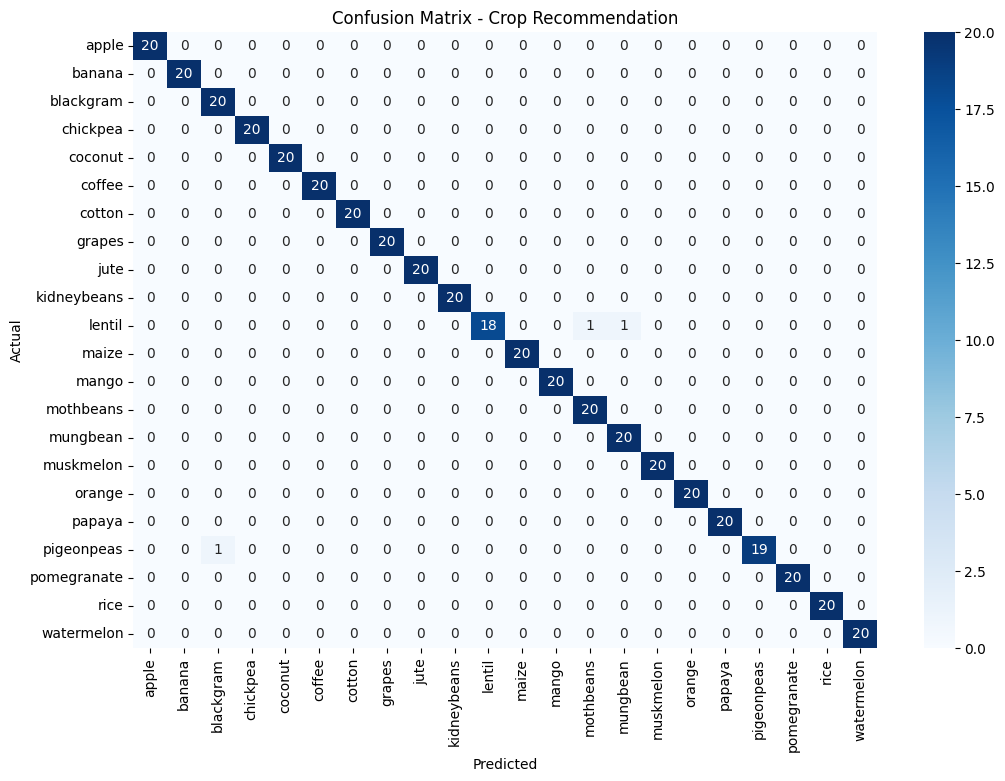

In [ ]:
cm = confusion_matrix(y_test, y_pred)
class_names = le.inverse_transform(range(len(le.classes_)))

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Crop Recommendation")
plt.show()

Test model on our data

In [ ]:
df2_model = df2.copy()
df2_model = xgb_pipeline.named_steps['feature_filter'].transform(df2_model)

In [ ]:
pred_encoded = xgb_pipeline.predict(df2_model)
df2['predicted_crop'] = le.inverse_transform(pred_encoded)

In [ ]:
# Probabilities -> top3
proba = xgb_pipeline.predict_proba(df2_model)
top3_idx = np.argsort(proba, axis=1)[:, -3:][:, ::-1]

In [ ]:
top3 = [le.inverse_transform(row) for row in top3_idx]
df2[['top1','top2','top3']] = pd.DataFrame(top3, index=df2.index)

In [ ]:
df2.head()

,year,month,sand,silt,clay,soc,ph,bdod,cec,ndvi,...,tp_m,ssrd_jm2,lc_type1,nitrogen,phosphorus,potassium,predicted_crop,top1,top2,top3
0,2017,1,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.23490,...,317.607101,5.313632e+09,50,0.317,35.0,142.6,coffee,coffee,rice,chickpea
1,2017,2,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.25945,...,114.083275,6.185134e+09,50,0.317,35.0,142.6,chickpea,chickpea,pigeonpeas,papaya
2,2017,3,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.26755,...,74.303685,2.725764e+09,50,0.317,35.0,142.6,chickpea,chickpea,blackgram,maize
3,2017,4,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.23695,...,56.937548,1.058778e+10,50,0.317,35.0,142.6,chickpea,chickpea,watermelon,mothbeans
4,2017,5,41.9,32.6,25.4,36.4,7.6,1.38,2.14,0.22175,...,30.640441,1.216407e+10,50,0.317,35.0,142.6,muskmelon,muskmelon,lentil,chickpea


In [ ]:
df2.isna().sum()

,0
year,0
month,0
sand,0
silt,0
clay,0
soc,216
ph,0
bdod,216
cec,0
ndvi,0


In [ ]:
df2['predicted_crop'].value_counts()

,count
predicted_crop,
mothbeans,1427
muskmelon,1197
pomegranate,242
chickpea,235
coffee,224
rice,103
watermelon,58
mango,25
lentil,21


In [ ]:
df2['predicted_crop'].unique()

array(['coffee', 'chickpea', 'muskmelon', 'mothbeans', 'rice', 'lentil',
       'papaya', 'pomegranate', 'watermelon', 'coconut', 'mungbean',
       'jute', 'mango', 'blackgram'], dtype=object)

Save needed files

In [ ]:
joblib.dump(xgb_pipeline, 'crop_pipeline.pkl')

['crop_pipeline.pkl']

In [ ]:
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']